## Dimensionality Reduction: Customer Segmentation with PCA

Porimol Chandro \
1st Year Master's Student of Data Science and Business Analytics \
Faculty of Economic Sciences, University of Warsaw

## Table of contents

1. Motivation(What Drives My Project Interest?)
2. Import required python packages
3. Dataset information
4. Load dataset
5. Datasets merging
6. Data Sampling
7. Exploratory Data Analysis(EDA)
    - The search for missings and duplicates
    - Visualizing missing values
    - Ploting the frequency values of categorical and numerical features
    - Get list of categorical and numerical variables
8. Selecting the appropriate features
    - One-hot encoding and scaling the features
    - MinMaxScaler
9. Clustering
    - Find the k based on elbow analysis
    - KMeans clustering
    - Distribution of the clusters
10. Dimensionality reduction using PCA
11. Exploring the data by cluster
12. Conclusion

## Motivation(What Drives My Project Interest?)

Whether we follow well thought-out grocery lists or let impulse dictate we eating, our distinct eating customs are what make us who we are. The goal of the grocery ordering and delivery software Instacart is to make it simple for us to stock our pantry and refrigerator with our go-to items and personal favourites whenever we need them. Personal shoppers choose products using the Instacart app, review our order, and handle both the in-store shopping and delivery.

Instacart's primary objective is to simplify the process of replenishing our pantry and refrigerator shelves with the items that define our preferences and reflect our individual tastes. In a world where time is of the essence and efficiency is paramount, Instacart steps in as a seamless solution, offering the flexibility to procure our go-to essentials and cherished favorites at our convenience.

This innovative platform operates through a network of personal shoppers who navigate the aisles using the Instacart app. These dedicated individuals meticulously curate our orders, ensuring that each item aligns with our specific choices and requirements. From the initial selection process to the final doorstep delivery, Instacart's personal shoppers undertake the responsibility of transforming our digital grocery lists into tangible, carefully chosen products.

## Importing required Python packages

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

## Dataset Information

The dataset I use Open Sourced Instacart Orders dataset(https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2).

In the following, I description all of the feature variables.

Orders:
- order_id: order identifier
- user_id: customer identifier
- eval_set: which evaluation set this order belongs in (see SET described below)
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- order_hour_of_day: the hour of the day the order was placed on
- days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

Products:
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

Aisles:
- aisle_id: aisle identifier
- aisle: the name of the aisle

Deptartments:
- department_id: department identifier
- department: the name of the department

Order products:
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

where SET is one of the four following evaluation sets (eval_set in orders):
- "prior": orders prior to that users most recent order
- "train": training data supplied to participants
- "test": test data reserved for machine learning competitions

## Load the data

Load all datasets

In [2]:
aisles_df = pd.read_csv("datasets/instacart/aisles.csv")
departments_df = pd.read_csv("datasets/instacart/departments.csv")
order_products_prior_df = pd.read_csv("datasets/instacart/order_products_prior.csv")
order_products_train_df = pd.read_csv("datasets/instacart/order_products_train.csv")
order_df = pd.read_csv("datasets/instacart/orders.csv")
products_df = pd.read_csv("datasets/instacart/products.csv")

Displaying the shape of the dataset and first 5 rows of each dataset

In [3]:
aisles_df.shape

(134, 2)

In [4]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
order_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## Datasets merging

Merging order_products_prior_df, order_df dataframe into one based on order_id

In [10]:
df = pd.merge(order_products_prior_df, order_df, on='order_id', how='inner')

In [11]:
df.shape

(32434489, 10)

In [12]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


Merging df, products_df dataframe into one based on product_id

In [13]:
df = pd.merge(df, products_df, on='product_id', how='inner')

In [14]:
df.shape

(32434489, 13)

In [15]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16


Merging df, aisles_df and departments_df dataframe into one based on aisle_id, department_id

In [16]:
df = pd.merge(df, aisles_df, on='aisle_id', how='inner')
df = pd.merge(df, departments_df, on='department_id', how='inner')

In [17]:
df.shape

(32434489, 15)

In [18]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


Dropping un-used variables

In [19]:
df = df.drop(['user_id', 'order_id', 'product_id', 'aisle_id', 'department_id', 'eval_set'], axis=1)

In [20]:
df.shape

(32434489, 9)

In [21]:
df.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department
0,1,1,3,5,9,8.0,Organic Egg Whites,eggs,dairy eggs
1,5,0,2,0,16,7.0,Organic Egg Whites,eggs,dairy eggs
2,13,0,11,6,8,10.0,Organic Egg Whites,eggs,dairy eggs
3,5,1,21,6,9,8.0,Organic Egg Whites,eggs,dairy eggs
4,28,1,48,0,12,9.0,Organic Egg Whites,eggs,dairy eggs


## Data Sampling

We have over 3 milliones of observation which is huge and for the analysis and I create a sample dataset.

> Note: My laptop hardwar wasn't good enough to handle this large amount datasets.

In [22]:
df = df.sample(frac=0.003, random_state=46)

In [23]:
df.shape

(97303, 9)

In [24]:
df.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department
13526759,2,1,9,1,9,6.0,Organic Granny Smith Apple,fresh fruits,produce
399185,8,1,6,3,16,9.0,Hard-Boiled Eggs,eggs,dairy eggs
12002672,5,1,55,4,10,3.0,Organic Strawberries,fresh fruits,produce
3486157,5,1,21,6,8,11.0,Feta Cheese Crumbles,packaged cheese,dairy eggs
4770806,1,0,5,1,16,7.0,Organic Sour Cream,other creams cheeses,dairy eggs


## Exploratory Data Analysis(EDA)

Descriptive statistics about the dataset

In [25]:
df.describe()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,97303.000000,97303.000000,97303.000000,97303.000000,97303.000000,91106.000000
mean,8.366998,0.590105,17.157087,2.744170,13.424273,11.075824
std,7.121863,0.491817,17.515597,2.091391,4.239575,8.752326
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,5.000000,1.000000,10.000000,5.000000
50%,6.000000,1.000000,11.000000,3.000000,13.000000,8.000000
75%,12.000000,1.000000,24.000000,5.000000,16.000000,15.000000
max,122.000000,1.000000,99.000000,6.000000,23.000000,30.000000


### The search for missings and duplicates

To understand completely the procedures that I ought to follow in order to clean the dataset. I examine the data's details.
examining each column's data type in our datasets

In [26]:
df.duplicated().value_counts()

False    97284
True        19
Name: count, dtype: int64

In [27]:
df.drop_duplicates(inplace=True)

Based on the above output, here are no duplicates value in the dataset.

Check the percentage of missing values in the dataset

In [28]:
df.isnull().sum()*100/df.shape[0]

add_to_cart_order         0.000000
reordered                 0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.354591
product_name              0.000000
aisle                     0.000000
department                0.000000
dtype: float64

We can see that in `days_since_prior_order` column we ahve 6% NULL values in the dataset, hence it is clean.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97284 entries, 13526759 to 4739599
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   add_to_cart_order       97284 non-null  int64  
 1   reordered               97284 non-null  int64  
 2   order_number            97284 non-null  int64  
 3   order_dow               97284 non-null  int64  
 4   order_hour_of_day       97284 non-null  int64  
 5   days_since_prior_order  91102 non-null  float64
 6   product_name            97284 non-null  object 
 7   aisle                   97284 non-null  object 
 8   department              97284 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 7.4+ MB


### Visualizing missing values

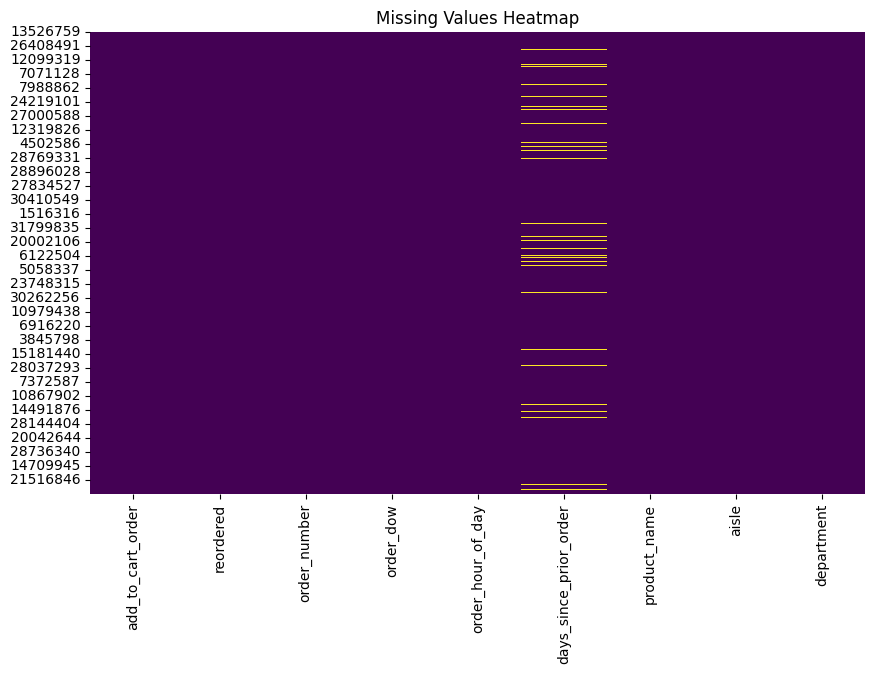

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

The heatmap shows the percentage of missing values for each feature in the dataset. The features are listed on the `y-axis`, and the percentage of missing values is shown on the `x-axis`. The color intensity corresponds to the percentage of missing values, with darker colors indicating a higher percentage of missing values.

Based on the heatmap, it appears that there are a significant number of missing values in some features, such as `add_to_cart_order`, `reordered`, `days_since_prior_order`, and `product_name`. It is important to consider how to handle these missing values before proceeding with any analysis of the data.

Here are some additional observations about the heatmap:
- There are no missing values in the features order_number, order_dow, and order_hour_of_day.
- The features with the highest percentage of missing values are all categorical features.
- There is a large variation in the percentage of missing values across different features.

In [31]:
df.fillna(df.days_since_prior_order.mean(), inplace=True)

In [32]:
len(df.aisle.unique()), len(df.department.unique()), len(df.product_name.unique())

(134, 21, 15912)

In [33]:
df.aisle.value_counts()

aisle
fresh fruits                  10805
fresh vegetables              10209
packaged vegetables fruits     5350
yogurt                         4446
packaged cheese                2907
                              ...  
baby bath body care              26
baby accessories                 26
kitchen supplies                 20
frozen juice                     16
beauty                           15
Name: count, Length: 134, dtype: int64

In [34]:
df.department.value_counts()

department
produce            28351
dairy eggs         16159
snacks              8641
beverages           8147
frozen              6822
pantry              5594
bakery              3521
canned goods        3178
deli                3159
dry goods pasta     2536
household           2258
breakfast           2230
meat seafood        2123
personal care       1335
babies              1253
international        774
alcohol              492
pets                 298
missing              201
bulk                 107
other                105
Name: count, dtype: int64

In [35]:
df.product_name.value_counts()

product_name
Banana                                1422
Bag of Organic Bananas                1044
Organic Strawberries                   844
Organic Baby Spinach                   730
Organic Hass Avocado                   647
                                      ... 
Original Sugar Free Coconut Milk         1
Organic Pretzel Sticks                   1
Hot House Seedless Cucumbers             1
Brown Sugar Cinnamon Roll Wafflers       1
P3 Turkey Cheese Almonds                 1
Name: count, Length: 15912, dtype: int64

### Ploting the frequency values of numerical features

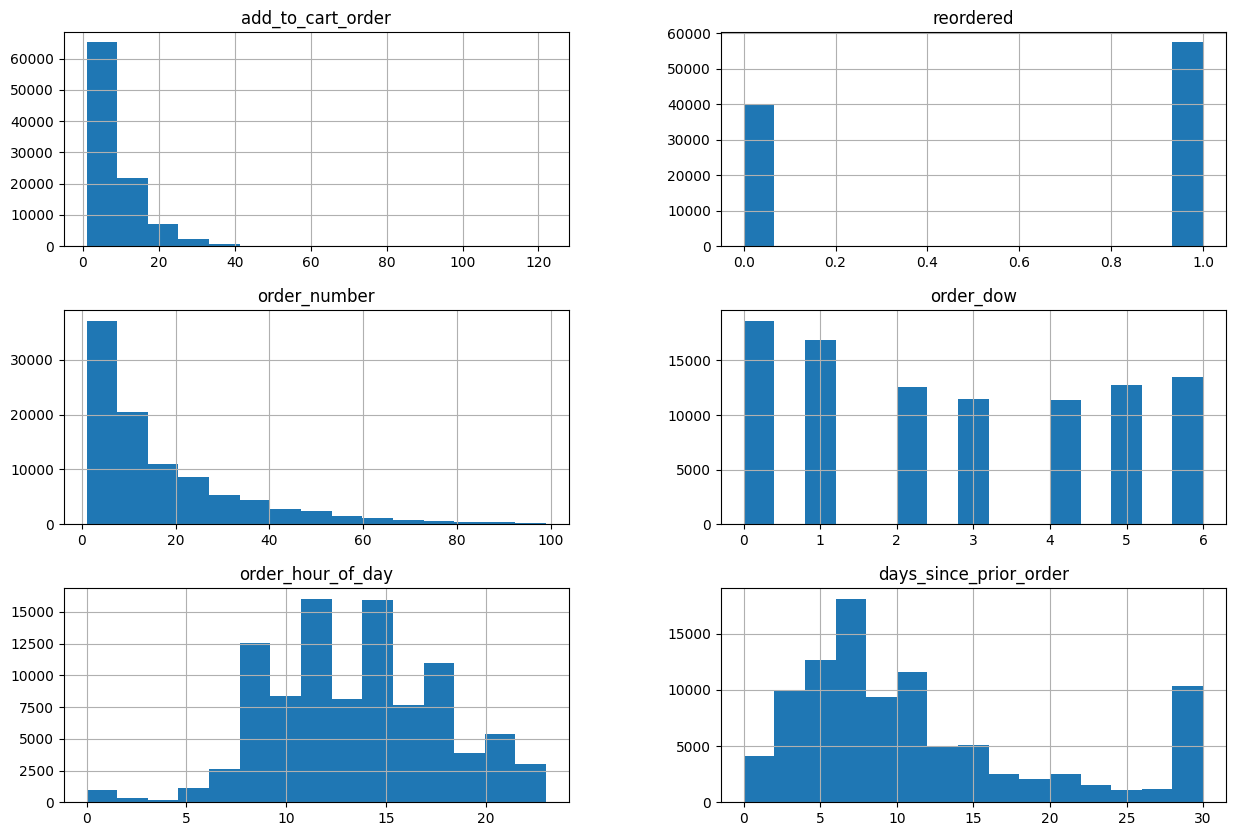

In [36]:
df.hist(bins=15, figsize=(15, 10))
plt.show()

The visualisation displays the dataset's numerical features' frequency values. Using a single order, the frequency values of the order number, order hour, and days are plotted in a histogram.

The feature values are plotted on the `x-axis`, and the number of orders that have each value is plotted on the `y-axis`. An example of this would be the order number histogram, which indicates that roughly 60,000 orders have an order number of 0 and roughly 50,000 have an order number of 1.

The order number, order hour, and days since previous order are all `right-skewed`, as can be seen from the histograms. This indicates that compared to orders with higher values, there are more orders with lower values of these attributes.

### Check unique value of each categorical features

In [37]:
num_feats = (df.dtypes != 'object')
num_feats = list(num_feats[num_feats].index)

cat_feats = (df.dtypes == 'object')
cat_feats = list(cat_feats[cat_feats].index)

print(f"Numerical features: {num_feats} \nCategorical features: {cat_feats}")

Numerical features: ['add_to_cart_order', 'reordered', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'] 
Categorical features: ['product_name', 'aisle', 'department']


### Calculating the correlation matrix

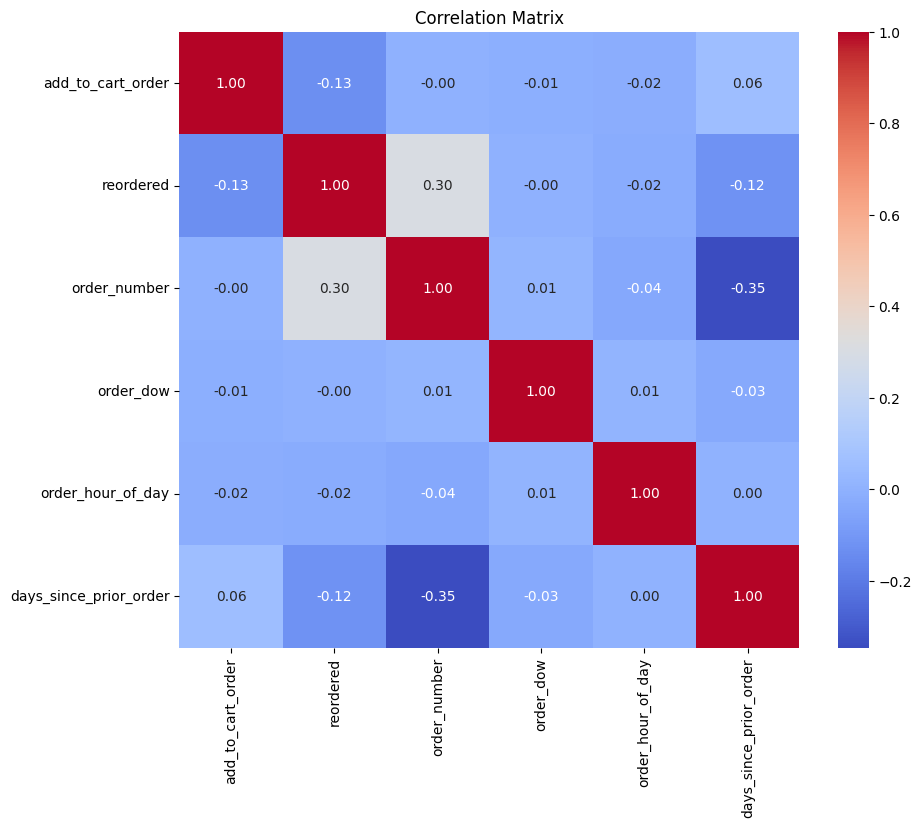

In [38]:
cor_matrix = df[num_feats].corr(method='pearson')
# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The Instacart market basket order variables' correlation matrix. It displays the relationship between every two attributes. The correlation coefficient is displayed in the appropriate cell, and the attributes are enumerated on the x- and y-axes. The correlation coefficient is a number between -1 and 1, where a perfect negative correlation is represented by a value of -1, no correlation at all by a value of 1, and a perfect positive correlation by a value of 1. Darker colours indicate a stronger correlation, and the intensity of the colour reflects the correlation's strength.

It appears that some of the features have weak positive associations with one another based on the heatmap. For instance, days_since_prior_order and reordered have a marginally positive association (0.12). This indicates that orders with reordered items—items that have already been purchased—usually arrive fewer days following the initial transaction. Additionally, there is a modest positive association (0.04) between days_since_prior_order and order_number. As a result, orders with larger order numbers are typically placed a shorter amount of time after the last order.

Nevertheless, the majority of the heatmap's associations are extremely weak or nearly nil. This shows that majority of the features in the Instacart market basket order dataset do not have a strong linear connection.

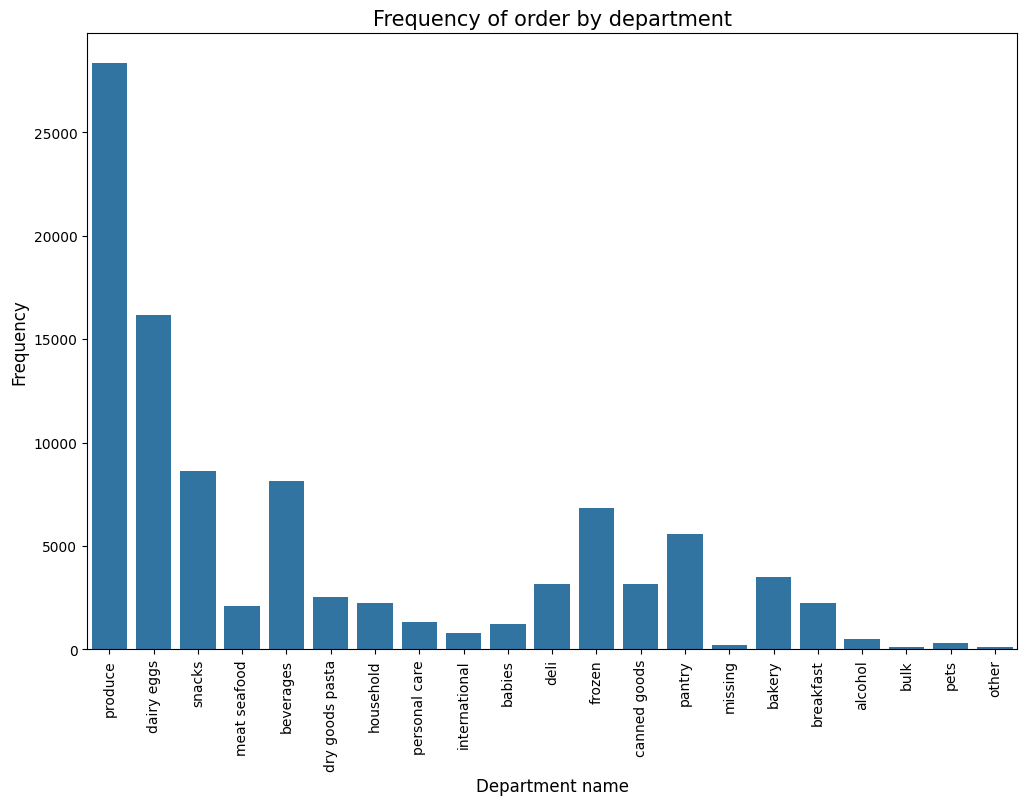

In [39]:
color = sns.color_palette()
plt.figure(figsize=(12,8))
sns.countplot(x="department", data=df, color=color[0])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Department name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by department", fontsize=15)
plt.show()

The bar graph showing the frequency of orders by department. The departments are listed on the x-axis, and the number of orders placed in each department is shown on the y-axis. The bars are colored to distinguish between different departments.

Based on the graph, it appears that the most frequent orders are placed in the produce department, followed by dairy and eggs, snacks, meat and seafood, and beverages. The least frequent orders are placed in the pets, bulk, alcohol, and bakery departments.

Here are some additional observations about the graph:
- There is a large difference in the number of orders placed in different departments. For example, there are more than twice as many orders placed in the produce department as in the dairy and eggs department.
- The number of orders placed in each department appears to be relatively consistent across different departments. There are no departments with a very high or very low number of orders compared to the other departments.

In [40]:
department_df = pd.get_dummies(df[['department']], drop_first=True)

In [41]:
department_df.shape

(97284, 20)

In [42]:
department_df.head()

,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
13526759,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
399185,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
12002672,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3486157,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4770806,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [43]:
department_df = department_df.astype(int)

In [44]:
department_df.head()

,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
13526759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
399185,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12002672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3486157,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4770806,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
department_df.rename(columns={key: key.replace('department_', '').replace(' ', '_') for key in department_df.keys()}, inplace=True)

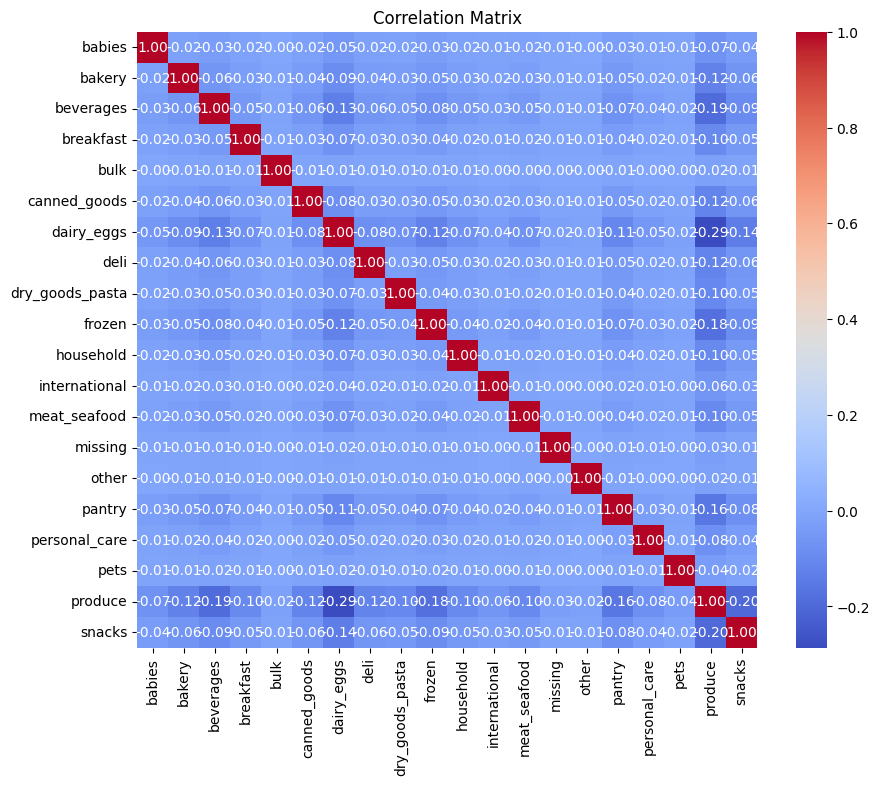

In [46]:
cor_matrix = department_df.corr(method='pearson')
# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix shows the correlation between each pair of features in the Instacart market basket order dataset. The features are listed on the x-axis and y-axis, and the correlation coefficient is shown in the corresponding cell. The correlation coefficient ranges from -1 to 1, where -1 indicates a perfect negative correlation, 0 indicates no correlation, and 1 indicates a perfect positive correlation. The color intensity corresponds to the strength of the correlation, with darker colors indicating a stronger correlation.

Based on the heatmap, it appears that there are some weak positive correlations between some of the features. For example, there is a weak positive correlation between reordered and days_since_prior_order (0.12). This means that orders that contain previously purchased items (reordered items) tend to be placed fewer days after the previous order. There is also a weak positive correlation between order_number and days_since_prior_order (0.04). This means that orders with higher order numbers tend to be placed fewer days after the previous order.

However, most of the correlations in the heatmap are very weak or close to zero. This suggests that there is not a strong linear relationship between most of the features in the Instacart market basket order dataset.

**Join the department dataframe with the original dataframe**

In [47]:
df = pd.concat([df, department_df], axis=1)

In [48]:
df.shape

(97284, 29)

In [49]:
df.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department,babies,...,household,international,meat_seafood,missing,other,pantry,personal_care,pets,produce,snacks
13526759,2,1,9,1,9,6.0,Organic Granny Smith Apple,fresh fruits,produce,0,...,0,0,0,0,0,0,0,0,1,0
399185,8,1,6,3,16,9.0,Hard-Boiled Eggs,eggs,dairy eggs,0,...,0,0,0,0,0,0,0,0,0,0
12002672,5,1,55,4,10,3.0,Organic Strawberries,fresh fruits,produce,0,...,0,0,0,0,0,0,0,0,1,0
3486157,5,1,21,6,8,11.0,Feta Cheese Crumbles,packaged cheese,dairy eggs,0,...,0,0,0,0,0,0,0,0,0,0
4770806,1,0,5,1,16,7.0,Organic Sour Cream,other creams cheeses,dairy eggs,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df.drop(['product_name', 'aisle', 'department'], axis=1, inplace=True)

In [51]:
df.shape

(97284, 26)

In [52]:
df.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,babies,bakery,beverages,breakfast,...,household,international,meat_seafood,missing,other,pantry,personal_care,pets,produce,snacks
13526759,2,1,9,1,9,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
399185,8,1,6,3,16,9.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12002672,5,1,55,4,10,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3486157,5,1,21,6,8,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4770806,1,0,5,1,16,7.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Dimensionality reduction using PCA

The vast amount of data within the Instacart dataset, encompassing diverse features like product purchases, order details, and customer information, presents a challenge for analysis.

This complexity arises from the high dimensionality, which can lead to:
- Increased computational costs: Training algorithms struggle with too many features, making analysis slow and resource-intensive.
- Overfitting: Models may prioritize memorizing irrelevant details instead of learning generalizable patterns.
- Difficulty in interpretation: Visualizing and understanding high-dimensional data is extremely challenging.


Principal Component Analysis (PCA) comes to the rescue as a dimensionality reduction technique. It identifies the most informative features (principal components) capturing the majority of the data's variance, effectively compressing the information into a lower-dimensional space.

This offers several benefits for the Instacart dataset:
- Improved efficiency: Analysis becomes faster and requires fewer resources, enabling quicker insights generation.
- Reduced overfitting: By focusing on essential features, models are less likely to memorize noise, leading to better generalization.
- Enhanced interpretability: Visualizing and understanding the reduced data space with key components is significantly easier.

Applying PCA to the Instacart dataset can reveal:
- Hidden patterns: Identifying underlying relationships between customer behavior, product choices, and order characteristics that might be obscured by the high dimensionality.
- Key customer segments: Grouping customers based on their purchase patterns and uncovering distinct buying behaviors.
- Product associations: Discovering frequently bought-together products, aiding in recommendation systems and marketing strategies.

By utilizing PCA, we can unlock valuable insights from the Instacart data, paving the way for improved customer segmentation, targeted marketing campaigns, and ultimately, a more data-driven approach to business decisions.

In [53]:
pca = PCA()
pca.fit(df[num_feats])

# Calculating eigenvalues from the PCA components
eigenvalues = pca.explained_variance_

# Creating a DataFrame for components and their corresponding eigenvalues
eigenvalues_df = pd.DataFrame({'Component': range(1, len(eigenvalues) + 1), 'Eigenvalue': eigenvalues})

**Creating a scree plot**

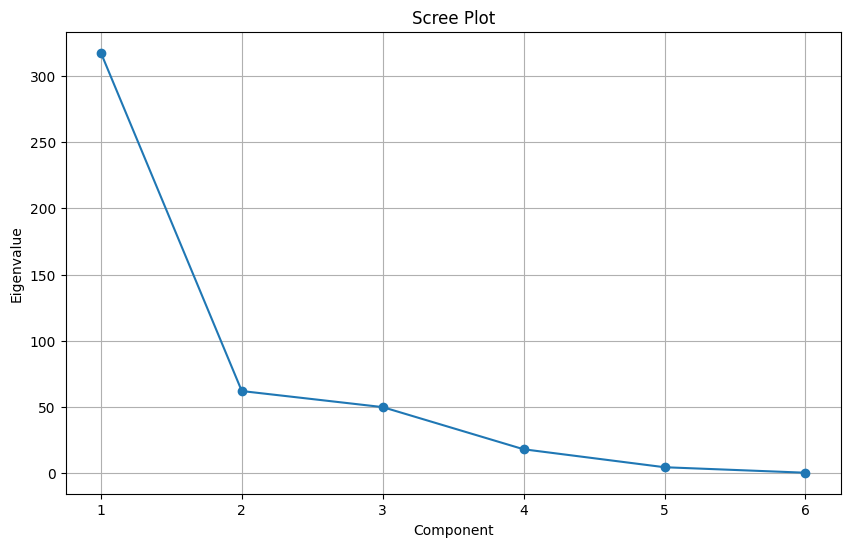

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues_df['Component'], eigenvalues_df['Eigenvalue'], marker='o')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

**The above scree plot is created before data standardization.**

Following are the key takeaways from the scree plot:

- The first few components capture most of the variance: The plot shows a steep decline in the eigenvalue values (which represent the amount of variance explained by each component) after the first few components. This indicates that the first few components capture a significant portion of the overall data variability, while subsequent components contribute less and less.
- The 'elbow' suggests an appropriate number of components: The scree plot exhibits a clear "elbow" shape, where the slope of the curve changes abruptly. This is a common heuristic to determine the number of components to retain.
In this case, the elbow occurs around the 4th or 5th component, suggesting that these components might be sufficient to represent the important information in the data while avoiding overfitting.


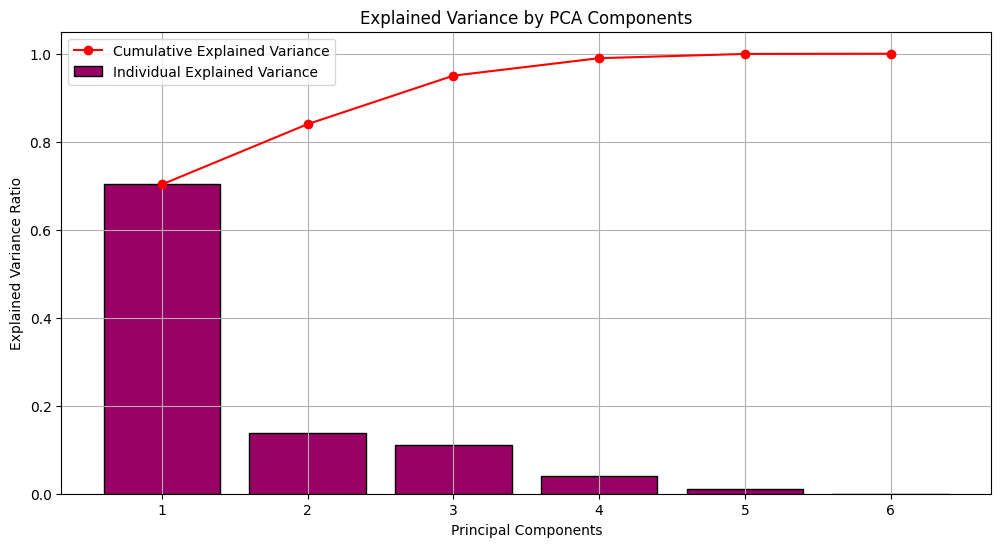

In [55]:
# Creating a figure for the plot
plt.figure(figsize=(12, 6))

# Creating a bar plot for the proportion of variance explained by each PCA component
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, 
        color="#990066", 
        edgecolor='black',
        label='Individual Explained Variance')

# Adding a line plot for the cumulative variance explained
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', 
         color="red", 
         label='Cumulative Explained Variance')

# Adding labels and title
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

**Explained Variance Ratio** plot visualized before data standardization.

The PCA Biplot visualizes the relationships between the features and the first two principal components (PC1 and PC2) of the Instacart dataset. Each dot represents a feature, and the distance between two dots reflects their correlation. The arrows represent the principal components, with the length of the arrow indicating the amount of variance explained by that component.

Based on the biplot, it appears that:
- PC1 explains a significant portion of the variance in the data, as its arrow is much longer than the arrow for PC2.
- Features on the right side of the plot are positively correlated with PC1, while features on the left side are negatively correlated.
- Features closer together are more correlated with each other, while features further apart are less correlated.

## Standardizing the data using StandardScaler

Before applying PCA to the Instacart dataset, standardizing the data with StandardScaler is crucial for a meaningful analysis. Imagine features like "order amount" in dollars and "number of items" as integers. Their vastly different scales would unfairly prioritize the feature with larger values during PCA, skewing the analysis.

Standardization addresses this by transforming each feature's values to have a mean of zero and a standard deviation of one. This essentially puts all features on a "level playing field," ensuring that PCA focuses on the inherent variability within each feature, not just its magnitude.

Here's why standardization is critical for PCA in the Instacart dataset:
- Fair comparison of features: By removing scale differences, features contribute equally to the analysis, preventing any single feature from dominating due to its scale.
- Improved interpretation: Principal components represent directions of maximum variance, and standardization ensures this variance reflects the data's inherent structure, not just differences in scale.
- Robustness to outliers: Standardizing reduces the impact of outliers, which can significantly affect PCA results without proper scaling.

In essence, standardization ensures that PCA captures the true underlying relationships between features in the Instacart dataset, leading to more accurate and interpretable results. It's like setting up a fair competition where each feature gets a chance to showcase its significance, independent of its original "loudness."
 

In [56]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [57]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [58]:
df_scaled.shape

(97284, 26)

In [59]:
df_scaled.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,babies,bakery,beverages,breakfast,...,household,international,meat_seafood,missing,other,pantry,personal_care,pets,produce,snacks
0,-0.894121,0.833307,-0.465815,-0.834045,-1.043563,-0.599313,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.154149,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,1.559299,-0.312219
1,-0.051672,0.833307,-0.637088,0.122244,0.607484,-0.245111,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.154149,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,-0.641314,-0.312219
2,-0.472897,0.833307,2.160361,0.600389,-0.807699,-0.953515,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.154149,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,1.559299,-0.312219
3,-0.472897,0.833307,0.219274,1.556678,-1.279426,-0.008976,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.154149,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,-0.641314,-0.312219
4,-1.034530,-1.200038,-0.694179,-0.834045,0.607484,-0.481245,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.154149,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,-0.641314,-0.312219


In [60]:
pca = PCA()
pca.fit(df_scaled)

# Calculating eigenvalues from the PCA components
eigenvalues = pca.explained_variance_

# Creating a DataFrame for components and their corresponding eigenvalues
eigenvalues_df = pd.DataFrame({'Component': range(1, len(eigenvalues) + 1), 'Eigenvalue': eigenvalues})


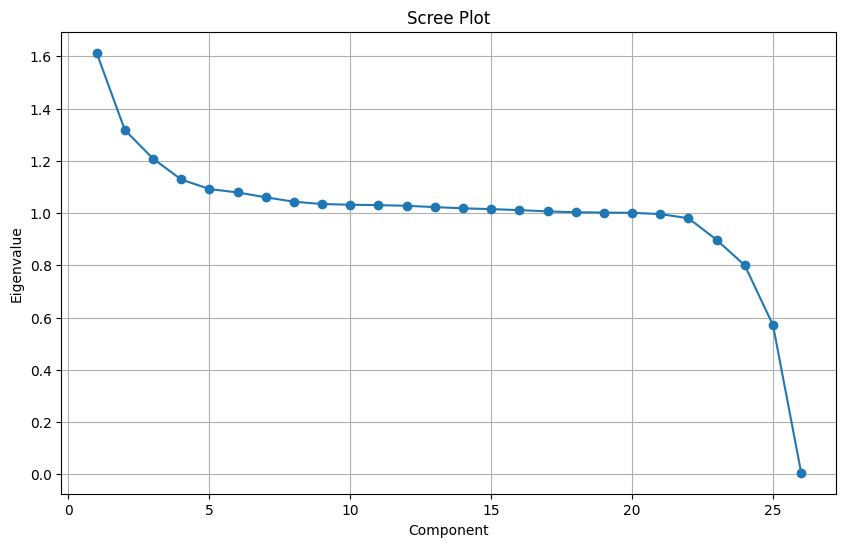

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues_df['Component'], eigenvalues_df['Eigenvalue'], marker='o')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

**The above scree plot is created after data standardization.**

Based on the scree plot, it appears that the first 4 or 5 components capture most of the variance in the Instacart dataset after performing Principal Component Analysis (PCA). This means that the first few components contain the most important information about the data, while the subsequent components contain less and less important information.

Here are some additional observations about the scree plot:
- The eigenvalue, which represents the amount of variance explained by each component, decreases rapidly after the first few components. This indicates that the first few components are more important for capturing the overall variability in the data.
- There is a clear "elbow" in the scree plot around the 4th or 5th component. This is a common heuristic used to determine the number of components to retain. In this case, the elbow suggests that retaining the first 4 or 5 components would be a good compromise between capturing the important information and avoiding overfitting.
- The exact number of components to retain can also be guided by other criteria, such as the desired level of explained variance or the interpretability of the components.
- It's important to remember that the scree plot is just a visual tool, and the optimal number of components may vary depending on the specific analysis goals.
Overall, the scree plot suggests that using the first 4 or 5 components after performing PCA on the Instacart dataset would be a good starting point for further analysis. However, it is important to consider other factors and potentially use additional techniques to determine the optimal number of components for your specific needs.

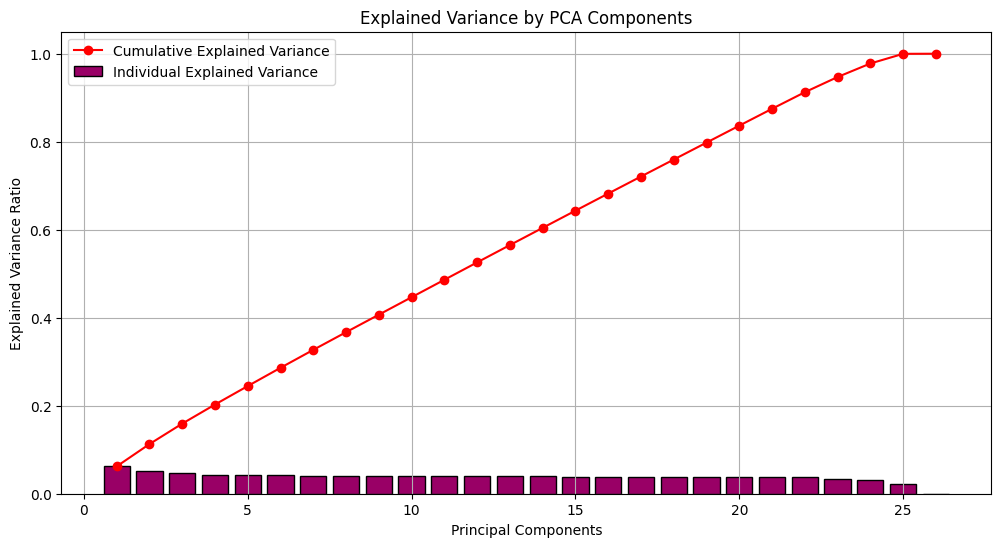

In [62]:
# Creating a figure for the plot
plt.figure(figsize=(12, 6))

# Creating a bar plot for the proportion of variance explained by each PCA component
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, 
        color="#990066", 
        edgecolor='black',
        label='Individual Explained Variance')

# Adding a line plot for the cumulative variance explained
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', 
         color="red", 
         label='Cumulative Explained Variance')

# Adding labels and title
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

**Explained Variance Ratio** plot visualized after data standardization.

The first few principal components capture a significant portion of the variance in the Instacart dataset. This is indicated by the rapid decrease in the explained variance ratio after the first few components. For example, if the first component explains 50% of the variance, and the second component only adds another 10%, then there's little benefit in including many more components beyond the first few.

The specific number of components to retain depends on your analysis goals and desired trade-off between explained variance and model complexity. In general, retaining more components will explain more of the variance in the data, but it also increases the risk of overfitting. The "elbow" in the plot is a common heuristic to guide selection, but other factors like interpretability of the components should also be considered.

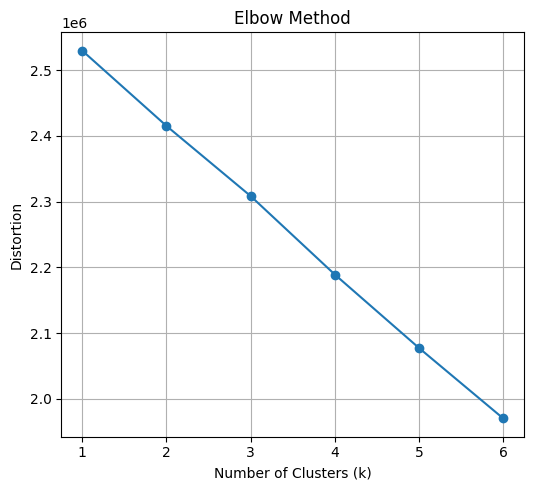

In [63]:
# Define a function to plot the elbow
max_clusters = 6
elbow_scores = []
silhouette_scores = []

# Calculate distortions and silhouette scores for different cluster numbers
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(df_scaled)
    elbow_scores.append(kmeans.inertia_)
    
    if k > 1:  # Silhouette score is not defined for a single cluster
        silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, max_clusters + 1), elbow_scores, marker='o')
# plt.axvline(4, linestyle='--', c='r')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.grid(True)

plt.tight_layout()
plt.show()

**Elbow method for determining the optimal number of clusters:**

The plot displays the distortion (often measured as the sum of squared distances within clusters) against the number of clusters (k), indicating how well the k-means algorithm fits the data with different cluster numbers. An "elbow" shape is typically sought to identify the optimal number of clusters.

Observations:
- Overall trend: The distortion generally decreases as the number of clusters increases, which is expected as more clusters can potentially better fit the data points.
- Elbow: While a definitive elbow isn't readily apparent, there might be a subtle bend around k=3 or 4. This suggests that adding more clusters beyond this point might not significantly improve the fit and could lead to overfitting.
- Distortion values: The distortion values seem relatively close across different k, making it slightly harder to pinpoint the elbow visually.

## Exploring the data by cluster

In [64]:
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, random_state=42)
kmeans_clusters = kmeans.fit_predict(df_scaled)

In [65]:
df_scaled['cluster_k'] = kmeans_clusters

In [66]:
df_scaled.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,babies,bakery,beverages,breakfast,...,international,meat_seafood,missing,other,pantry,personal_care,pets,produce,snacks,cluster_k
0,-0.894121,0.833307,-0.465815,-0.834045,-1.043563,-0.599313,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,1.559299,-0.312219,1
1,-0.051672,0.833307,-0.637088,0.122244,0.607484,-0.245111,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,-0.641314,-0.312219,2
2,-0.472897,0.833307,2.160361,0.600389,-0.807699,-0.953515,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,1.559299,-0.312219,1
3,-0.472897,0.833307,0.219274,1.556678,-1.279426,-0.008976,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,-0.641314,-0.312219,2
4,-1.034530,-1.200038,-0.694179,-0.834045,0.607484,-0.481245,-0.114227,-0.193784,-0.302322,-0.153168,...,-0.089554,-0.149364,-0.045502,-0.032871,-0.247002,-0.117956,-0.055431,-0.641314,-0.312219,2


In [67]:
pca = PCA(2)
pca_df = pd.DataFrame(pca.fit_transform(df_scaled), columns=['pca0', 'pca1'])

In [68]:
pca_df.head()

,pca0,pca1
0,-0.154728,1.400722
1,-1.535489,-0.704430
2,-0.769447,2.860632
3,-1.819929,-0.253640
4,-1.051001,-1.326957


In [69]:
pca_df['cluster_ks'] = kmeans_clusters

In [70]:
pca_df.head()

,pca0,pca1,cluster_ks
0,-0.154728,1.400722,1
1,-1.535489,-0.704430,2
2,-0.769447,2.860632,1
3,-1.819929,-0.253640,2
4,-1.051001,-1.326957,2


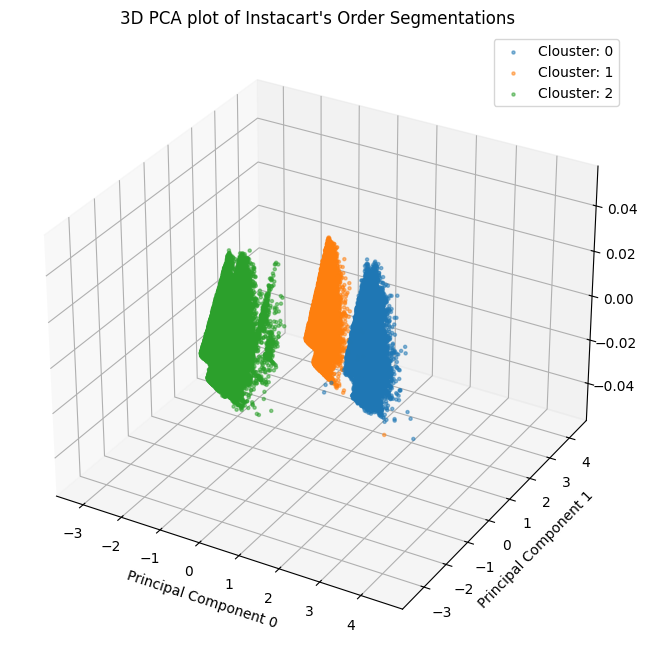

In [71]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
for cluster_num in np.unique(kmeans_clusters):
    ax.scatter(pca_df[kmeans_clusters == cluster_num]['pca0'],
               pca_df[kmeans_clusters == cluster_num]['pca1'],
               label=f"Clouster: {cluster_num}",
               s=5,
               alpha=0.5,
               marker='o',)
plt.title("3D PCA plot of Instacart's Order Segmentations")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.legend()
plt.show()

## Conclusion

A three-dimensional PCA plot of Instacart's order segmentation is visible in the cluster visualisation. Principal Component Analysis, or PCA, is a dimensionality reduction method that assists in locating and compressing a dataset's most crucial properties into a lower-dimensional space.

This helps with marketing and segmentation in a number of ways:

1. Finding hidden client segments: We can find patterns in our customer data that are not immediately visible from the raw data by examining the primary components. Our consumers can then be divided into groups based on shared traits or behaviours by using these patterns.

2. Recognising client behaviour: We can better grasp the relationships between various customer groups by visualising the major components in a lower-dimensional environment. This can assist us in creating marketing initiatives that are more likely to be relevant to each target category.

3. Reducing overfitting: Overfitting occurs when we try to build a segmentation model using every characteristic in our data. When a model memorises the particular training data too well and struggles to generalise to new data, it is said to be overfitting. Through the reduction of features in the model, PCA can aid in the reduction of overfitting.

4. Enhancing marketing campaign performance: We can enhance the effectiveness of your marketing campaigns by segmenting our consumer base and better targeting them with PCA. Sales, conversion rates, and customer happiness may all rise as a result.

The three axes in the particular instance of the Instacart 3D PCA graphic most likely correspond to the principal components that were found to be the most significant based on the order data. Instacart could be able to identify client categories based on their ordering patterns by looking at the locations of various orders in this area.

> For example, one segment might consist of customers who frequently order groceries, while another segment might consist of customers who primarily order prepared meals.

All things considered, PCA is an effective tool for creating more effective segmentation plans and focused marketing efforts. In order to better understand our customers and develop more successful marketing efforts, we can use PCA to find hidden patterns in our customer data.